# Simulación de Data Drift con Detección de Pérdida de Performance

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import math

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/steel_energy.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.head()


Mounted at /content/drive


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


## Entrenamiento y baseline

In [2]:

target = 'Usage_kWh'
features = [c for c in df.columns if c not in ['date', target]]

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

num_feats = train_df[features].select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = [c for c in features if c not in num_feats]

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipe = Pipeline([
    ('pre', preprocess),
    ('model', model)
])

pipe.fit(train_df[features], train_df[target])

pred_val = pipe.predict(val_df[features])
baseline_rmse = math.sqrt(mean_squared_error(val_df[target], pred_val))
baseline_r2 = r2_score(val_df[target], pred_val)

baseline_rmse, baseline_r2


(1.0536206008382916, 0.9990109293157846)

## Simulación de Drift

In [3]:

df_mon = val_df.copy()

# Drift 1: shift de media
df_mon['Lagging_Current_Reactive.Power_kVarh'] *= 1.5

# Drift 2: missing values
idx = df_mon.sample(frac=0.15, random_state=7).index
df_mon.loc[idx, 'Lagging_Current_Power_Factor'] = np.nan

# Drift 3: componente estacional
df_mon['NSM'] = df_mon['NSM'] + np.sin(np.linspace(0, 6*np.pi, len(df_mon))) * 100

pred_mon = pipe.predict(df_mon[features])
monitor_rmse = math.sqrt(mean_squared_error(df_mon[target], pred_mon))
monitor_r2 = r2_score(df_mon[target], pred_mon)

monitor_rmse, monitor_r2


(6.95426687802656, 0.9569114847835817)

## PSI para feature con drift

In [4]:

def psi(expected, actual, buckets=10):
    expected = expected.dropna()
    actual = actual.dropna()
    q = np.linspace(0,1,buckets+1)
    breakpoints = np.unique(np.quantile(expected, q))
    eps = 1e-6

    exp_hist, _ = np.histogram(expected, bins=breakpoints)
    act_hist, _ = np.histogram(actual, bins=breakpoints)

    exp_dist = np.where(exp_hist==0, eps, exp_hist) / exp_hist.sum()
    act_dist = np.where(act_hist==0, eps, act_hist) / act_hist.sum()

    return np.sum((exp_dist - act_dist) * np.log(exp_dist / act_dist))

psi_val = psi(val_df['Lagging_Current_Reactive.Power_kVarh'], df_mon['Lagging_Current_Reactive.Power_kVarh'])
psi_val


np.float64(0.5946947098520823)

## Gráficas

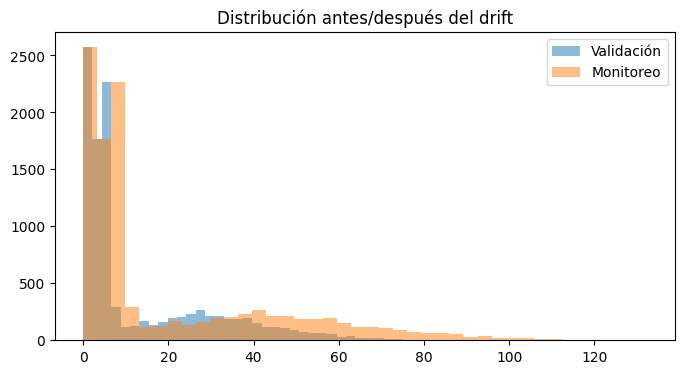

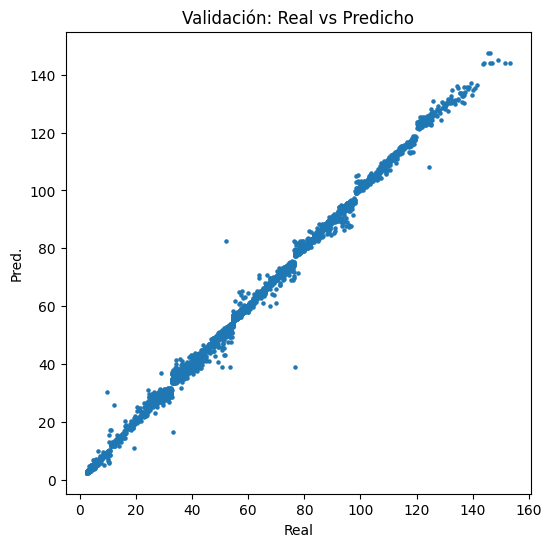

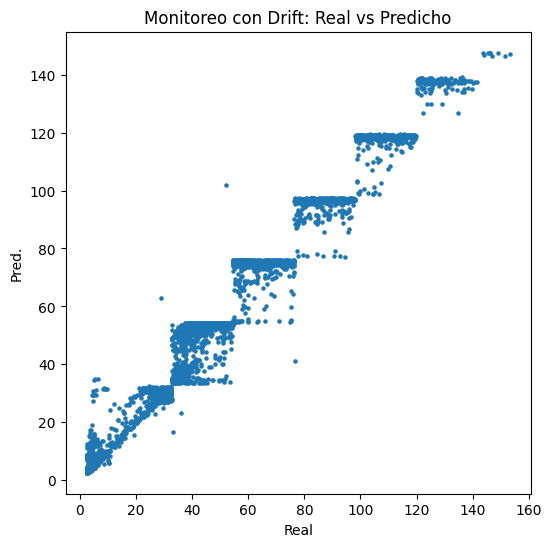

In [5]:

plt.figure(figsize=(8,4))
plt.hist(val_df['Lagging_Current_Reactive.Power_kVarh'], bins=40, alpha=0.5, label='Validación')
plt.hist(df_mon['Lagging_Current_Reactive.Power_kVarh'], bins=40, alpha=0.5, label='Monitoreo')
plt.legend()
plt.title('Distribución antes/después del drift')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(val_df[target], pred_val, s=5)
plt.title('Validación: Real vs Predicho')
plt.xlabel('Real')
plt.ylabel('Pred.')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_mon[target], pred_mon, s=5)
plt.title('Monitoreo con Drift: Real vs Predicho')
plt.xlabel('Real')
plt.ylabel('Pred.')
plt.show()
